In [1]:
import numpy as np
import cv2 as cv
import os

In [3]:
video_path = "../data/raw/test_video2.mp4"
video = cv.VideoCapture(video_path)

In [4]:
width = int(video.get(cv.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv.CAP_PROP_FRAME_HEIGHT))
fps = video.get(cv.CAP_PROP_FPS)
frame_count = int(video.get(cv.CAP_PROP_FRAME_COUNT))

In [5]:
width, height, fps, frame_count

(1280, 720, 28.726484264353843, 382)

In [ ]:
# let's get the first frame

# set to the first frame
video.set(cv.CAP_PROP_POS_FRAMES, 0)

# get the frame
check, first_frame = video.read()

# let's get the last frame
video.set(cv.CAP_PROP_POS_FRAMES, int(video.get(cv.CAP_PROP_FRAME_COUNT))-1)

# get the frame
check, last_frame = video.read()

# save the frames
cv.imwrite('first_frame.png', first_frame)

cv.imwrite('last_frame.png', last_frame)


True

In [ ]:
cv.destroyAllWindows()

video.release()

## testing the extract_frames function

In [12]:
def extract_frames(video_path, output_path):
    """
    input:
        video_path - path to the video.
        output_path - path where to save the frames.
    
    output:
        - returns a list of frame paths and there timings when they appear
    """
    result = []
    vid = cv.VideoCapture(video_path)
    
    # check we got the video
    if not vid.isOpened():
        print("Cannot open video")
        exit()
        
    # let's calculate the total duration of the video
    fps = vid.get(cv.CAP_PROP_FPS)
    total_frame = vid.get(cv.CAP_PROP_FRAME_COUNT)
    vid_duration = (total_frame/fps) * 1000
    
    # start at 0 milisecs
    current_time_ms = 0
    frame_cnt = 0
    
    while True:
        # check of the video is ended then break if false
        if current_time_ms < vid_duration:
            # jump to specific time
            vid.set(cv.CAP_PROP_POS_MSEC, current_time_ms)
            
            # read the frame
            ret, frame = vid.read()
            
            # getting the current time 
            time_frame = current_time_ms/1000
            
            # save the frame
            path = f"{output_path}/{frame_cnt+1}_ts_{time_frame}.jpg"
            cv.imwrite(path, frame)
            
            frame_cnt += 1
            current_time_ms += 1000
            
            result.append((path, time_frame))
        else:
            break
    
    return result

In [13]:
result = extract_frames(video_path="../data/raw/test_video2.mp4", output_path="../data/processed")

## Testing the face_detector functionality

In [2]:
from deepface import DeepFace
import mediapipe as mp

2025-12-05 12:22:16.547055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764937336.747143    1407 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764937336.807068    1407 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-05 12:22:17.289065: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    static_image_mode=True,
    max_num_faces=1,
    refine_landmarks=True,
    min_detection_confidence=0.5
)

libEGL warning: DRI3: Screen seems not DRI3 capable
libEGL warning: DRI3: Screen seems not DRI3 capable
MESA: error: ZINK: failed to choose pdev
libEGL warning: egl: failed to create dri2 screen
I0000 00:00:1764905921.796921    1095 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764905921.970025    1825 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon (TM) Graphics)


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1764905922.011011    1815 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764905922.080261    1823 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [ ]:
img = cv.imread()

In [8]:
def get_face_data(image_path, pad: float):
    """
    Input: Path to image
    Output:
        - face_crop: The cropped numpy array (ready for DeepFace)
        - landmarks: The raw mesh points (ready for Gaze Math)
    """
    
    img = cv.imread(image_path)
    # check
    if img is None:
        print(f"Error: Could not load {image_path}")
        return None, None
    
    h, w, _ = img.shape
    
    # convert to rgb and process it
    img_rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    # ready to be passed to get the face_mesh
    results = face_mesh.process(img_rgb)
    
    # check
    if not results.multi_face_landmarks:
        return None, None
    
    # Assuming one face
    landmarks = results.multi_face_landmarks[0].landmark
    
    # part-A calculating the bounding box from mesh
    
    # extract all x and y coordinates 
    x_coords = [p.x for p in landmarks]
    y_coords = [p.y for p in landmarks]
    
    x_min = int(min(x_coords) * w)
    x_max = int(max(x_coords) * w)
    y_min = int(min(y_coords) * h)
    y_max = int(max(y_coords) * h)
    
    # print("x_coords: ", x_coords)
    # print("y_coords: ", y_coords)
    
    # Applying the padding
    face_w = x_max - x_min
    face_h = y_max - y_min
    
    # 20% padding
    pad_x = int(face_w * pad)
    pad_y = int(face_h * pad)
    
    # applying padding with boundary checks
    crop_x1 = max(0, x_min - pad_x)
    crop_y1 = max(0, y_min - pad_y)
    crop_x2 = min(w, x_max + pad_x)
    crop_y2 = min(h, y_max + pad_y)
    
    # crop and return
    face_crop = img[crop_y1:crop_y2, crop_x1:crop_x2]
    
    return face_crop, landmarks
    

In [9]:
face_crop, lm = get_face_data(image_path="../data/processed/1_ts_0.0.jpg", pad=0.2)

W0000 00:00:1764905947.306013    1814 landmark_projection_calculator.cc:186] Using NORM_RECT without IMAGE_DIMENSIONS is only supported for the square ROI. Provide IMAGE_DIMENSIONS or use PROJECTION_MATRIX.


In [15]:
# Test on one of your saved frames
test_path = "../data/processed/2_ts_1.0.jpg" 

crop, landmarks = get_face_data(image_path=test_path, pad=0.2)

if crop is not None:
    # Show the crop (This is what DeepFace will see)
    cv.imshow("DeepFace Input (Padded)", crop)
    print(f"Success! Cropped shape: {crop.shape}")
    
    # save it
    cv.imwrite("../data/processed/cropped/2_ts_1.0_crop.jpg", crop)
    
    # Verify we still have landmarks for Gaze Logic
    print(f"Landmark 468 (Iris) X: {landmarks[468].x}")
    
    cv.waitKey(0)
    cv.destroyAllWindows()
else:
    print("No face detected.")

Success! Cropped shape: (379, 332, 3)
Landmark 468 (Iris) X: 0.48172643780708313


In [ ]:
lm

## Now, Let's try to pass the cropped image to deepface

In [3]:
results = DeepFace.analyze(img_path="../data/processed/cropped/2_ts_1.0_crop.jpg", actions=['emotion'])

2025-12-05 03:59:44.798557: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


25-12-05 03:59:45 - facial_expression_model_weights.h5 will be downloaded...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /home/adi_6200_/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:08<00:00, 673kB/s] 


In [4]:
results

[{'emotion': {'angry': 0.17388486303389072,
   'disgust': 9.764790753763464e-07,
   'fear': 1.5524779446423054,
   'happy': 0.006974869756959379,
   'sad': 2.214517258107662,
   'surprise': 2.6190579660578805e-05,
   'neutral': 96.05211615562439},
  'dominant_emotion': 'neutral',
  'region': {'x': 28,
   'y': 34,
   'w': 275,
   'h': 275,
   'left_eye': (195, 131),
   'right_eye': (99, 142)},
  'face_confidence': 0.94}]

## Let's try different approach for facial-expression analysis

In [29]:
image_path = "../data/processed/2_ts_1.0.jpg"

In [30]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

In [31]:
# path to the model file(downloaded using wget)
model_path = "../models/face_landmarker.task"

# This just let's mediapipe know where is the .task(model) weights of the model
base_options = python.BaseOptions(model_asset_path=model_path)

# Start the Face detector engine
options = vision.FaceLandmarkerOptions(
    base_options=base_options,
    output_face_blendshapes=True,
    # output_face_landmarks=True,
    num_faces=1,
    min_face_detection_confidence=0.5,
    running_mode=vision.RunningMode.IMAGE
)

# initialize the detector
detector = vision.FaceLandmarker.create_from_options(options)

I0000 00:00:1764939072.559138    1407 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764939072.751226    6483 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon (TM) Graphics)
W0000 00:00:1764939072.786013    1407 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1764939072.866353    6484 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764939072.942783    6489 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [32]:
image = mp.Image.create_from_file(image_path)

In [33]:
results = detector.detect(image)

In [34]:
categories = [category.category_name for category in results.face_blendshapes[0]]

In [55]:
results.face_blendshapes[0]

[Category(index=0, score=1.7647427341671573e-07, display_name='', category_name='_neutral'),
 Category(index=1, score=0.017574042081832886, display_name='', category_name='browDownLeft'),
 Category(index=2, score=0.01623484119772911, display_name='', category_name='browDownRight'),
 Category(index=3, score=0.0070070624351501465, display_name='', category_name='browInnerUp'),
 Category(index=4, score=0.23758423328399658, display_name='', category_name='browOuterUpLeft'),
 Category(index=5, score=0.1589314341545105, display_name='', category_name='browOuterUpRight'),
 Category(index=6, score=7.764123438391834e-06, display_name='', category_name='cheekPuff'),
 Category(index=7, score=6.843578859161425e-08, display_name='', category_name='cheekSquintLeft'),
 Category(index=8, score=7.963821957446271e-08, display_name='', category_name='cheekSquintRight'),
 Category(index=9, score=0.18506686389446259, display_name='', category_name='eyeBlinkLeft'),
 Category(index=10, score=0.15682026743888

In [35]:
categories

['_neutral',
 'browDownLeft',
 'browDownRight',
 'browInnerUp',
 'browOuterUpLeft',
 'browOuterUpRight',
 'cheekPuff',
 'cheekSquintLeft',
 'cheekSquintRight',
 'eyeBlinkLeft',
 'eyeBlinkRight',
 'eyeLookDownLeft',
 'eyeLookDownRight',
 'eyeLookInLeft',
 'eyeLookInRight',
 'eyeLookOutLeft',
 'eyeLookOutRight',
 'eyeLookUpLeft',
 'eyeLookUpRight',
 'eyeSquintLeft',
 'eyeSquintRight',
 'eyeWideLeft',
 'eyeWideRight',
 'jawForward',
 'jawLeft',
 'jawOpen',
 'jawRight',
 'mouthClose',
 'mouthDimpleLeft',
 'mouthDimpleRight',
 'mouthFrownLeft',
 'mouthFrownRight',
 'mouthFunnel',
 'mouthLeft',
 'mouthLowerDownLeft',
 'mouthLowerDownRight',
 'mouthPressLeft',
 'mouthPressRight',
 'mouthPucker',
 'mouthRight',
 'mouthRollLower',
 'mouthRollUpper',
 'mouthShrugLower',
 'mouthShrugUpper',
 'mouthSmileLeft',
 'mouthSmileRight',
 'mouthStretchLeft',
 'mouthStretchRight',
 'mouthUpperUpLeft',
 'mouthUpperUpRight',
 'noseSneerLeft',
 'noseSneerRight']

In [36]:
len(categories)

52

## Gaze Calculation

In [37]:
face_lm = results.face_landmarks[0]

In [38]:
type(face_lm), len(face_lm)

(list, 478)

In [39]:
def draw_landmarks_on_image(rgb_image, detection_result):
    """
    Inputs:
      rgb_image: The numpy array of the image (height, width, 3)
      detection_result: The result object from FaceLandmarker
    Output:
      annotated_image: Image with dots drawn on it
    """
    face_landmarks_list = detection_result.face_landmarks
    
    # Create a copy so we don't modify the original
    annotated_image = np.copy(rgb_image)
    height, width, _ = annotated_image.shape

    # Loop through all faces (usually just 1)
    for face_landmarks in face_landmarks_list:
        
        # 1. Draw ALL 478 points (Small Green Dots)
        for idx, landmark in enumerate(face_landmarks):
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            
            # Draw tiny green dot
            cv.circle(annotated_image, (x, y), 1, (0, 255, 0), -1)

        # 2. Highlight GAZE Points (Large Red Dots)
        # These are the specific indices we use for the Ratio Math
        # [Iris, Inner, Outer, Top, Bottom] for both eyes
        gaze_indices = [
            468, 473,       # Irises
            263, 362,       # Left Eye Horizontal
            33, 133,        # Right Eye Horizontal
            386, 374,       # Left Eye Vertical
            159, 145        # Right Eye Vertical
        ]
        
        for idx in gaze_indices:
            landmark = face_landmarks[idx]
            x = int(landmark.x * width)
            y = int(landmark.y * height)
            
            # Draw larger Red dot
            cv.circle(annotated_image, (x, y), 3, (255, 0, 0), -1)

    return annotated_image

In [40]:
img = cv.imread(image_path)

In [41]:
u_img = draw_landmarks_on_image(rgb_image=img, detection_result=results)

In [54]:
cv.imshow(winname="oyee", mat=u_img)
cv.waitKey(0)
cv.destroyAllWindows()

In [43]:
# RIGHT EYE (User's Right)
R_IRIS_CENTER = 468
R_INNER_CORNER = 133  # Toward nose
R_OUTER_CORNER = 33   # Toward ear
R_TOP_LID = 159
R_BOTTOM_LID = 145

# LEFT EYE (User's Left)
L_IRIS_CENTER = 473
L_INNER_CORNER = 362  # Toward nose
L_OUTER_CORNER = 263  # Toward ear
L_TOP_LID = 386
L_BOTTOM_LID = 374

In [44]:
face_lm

[NormalizedLandmark(x=0.5311570167541504, y=0.5366289019584656, z=-0.01922839693725109, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5288518071174622, y=0.4822036027908325, z=-0.04396159574389458, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5297915935516357, y=0.4963189661502838, z=-0.020645039156079292, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5200473070144653, y=0.43347302079200745, z=-0.03667005896568298, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5283228754997253, y=0.46773216128349304, z=-0.04803217574954033, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5278087854385376, y=0.44768208265304565, z=-0.04623647406697273, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5267026424407959, y=0.39816662669181824, z=-0.02843097597360611, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.467645525932312, y=0.3950824439525604, z=0.005405022297054529, visibility=0.0, presence=0.0),
 NormalizedLandmark(x=0.5251134037971497, y=

In [45]:
def get_coordinates(landmarks: list, idx: int) -> tuple:
    return (landmarks[idx].x, landmarks[idx].y)

In [46]:
r_iris_center_coor = get_coordinates(landmarks=face_lm, idx=R_IRIS_CENTER)

In [47]:
r_iris_center_coor

(0.48154395818710327, 0.38951098918914795)

In [48]:
import math
def euclidean_distance(coord1: tuple, coord2: tuple) -> float:
    return math.sqrt((coord1[0] - coord2[0])**2 + (coord1[1] - coord2[1])**2)

In [49]:
def calculate_gaze_ratios(landmarks: list) -> tuple:
    """
    Inputs:
        landmarks: resultant landmarks coordinates of all the important points on the face.
    Output:
        returns: (horizontal gaze ratio, vertical gaze ratio)
    """
    # important indexes in the landmark result.
    # RIGHT EYE (User's Right)
    R_IRIS_CENTER = 468
    R_INNER_CORNER = 133  # Toward nose
    R_OUTER_CORNER = 33   # Toward ear
    R_TOP_LID = 159
    R_BOTTOM_LID = 145

    # LEFT EYE (User's Left)
    L_IRIS_CENTER = 473
    L_INNER_CORNER = 362  # Toward nose
    L_OUTER_CORNER = 263  # Toward ear
    L_TOP_LID = 386
    L_BOTTOM_LID = 374
    
    # Calculating Horizontal Gaze ratio
    # For right eye
    # getting important coordinates
    r_iris_center_coor = get_coordinates(landmarks=landmarks, idx=R_IRIS_CENTER)
    r_inner_corner_coor = get_coordinates(landmarks=landmarks, idx=R_INNER_CORNER)
    r_outer_corner_coor = get_coordinates(landmarks=landmarks, idx=R_OUTER_CORNER)
    
    # getting the distances
    r_inner_d = euclidean_distance(coord1=r_iris_center_coor, coord2=r_inner_corner_coor)
    r_outer_inner_d = euclidean_distance(coord1=r_inner_corner_coor, coord2=r_outer_corner_coor)
    
    # right eye ratio
    rh_ratio = r_inner_d/r_outer_inner_d
    
    # for left eye
    # getting important coordinates
    l_iris_center_coor = get_coordinates(landmarks=landmarks, idx=L_IRIS_CENTER)
    l_inner_corner_coor = get_coordinates(landmarks=landmarks, idx=L_INNER_CORNER)
    l_outer_corner_coor = get_coordinates(landmarks=landmarks, idx=L_OUTER_CORNER)
    
    # getting the distances
    l_outer_d = euclidean_distance(coord1=l_iris_center_coor, coord2=l_outer_corner_coor)
    l_outer_inner_d = euclidean_distance(coord1=l_inner_corner_coor, coord2=l_outer_corner_coor)
    
    # left eye ratio
    lh_ratio = l_outer_d/l_outer_inner_d
    
    # horizontal gaze ratio
    h_ratio = (rh_ratio + lh_ratio)/2
    
    # Calculating Vertical Gaze ratio
    # for right eye
    ry_center = (r_inner_corner_coor[1] + r_outer_corner_coor[1])/2
    r_offset = r_iris_center_coor[1] - ry_center
    rv_ratio = r_offset/r_outer_inner_d
    
    # for left eye
    ly_center = (l_inner_corner_coor[1] + l_outer_corner_coor[1])/2
    l_offset = l_iris_center_coor[1] - ly_center
    lv_ratio = l_offset/l_outer_inner_d
    
    # vertical gaze ratio
    v_ratio = (rv_ratio + lv_ratio)/2
    
    return (h_ratio, v_ratio)

In [50]:
ratios = calculate_gaze_ratios(landmarks=face_lm)

In [51]:
ratios

(0.49507569902019505, -0.041122953581469765)

## Creating a function that converts this all into a dataframe

In [69]:
import pandas as pd
from pathlib import Path

def face_analysis_data(model_path, images_path) -> pd.DataFrame:
    """
    Inputs:
        model_path - mediapipe model weights file path
        images_path - path of the files where we saved the frame by frame images of the video.
    
    Output:
        fa_data - Time-Series data about the face emotions changing frame by frame in the video.
    """
    # Initializing the DataFrame
    fa_data = []
    
    folder = Path(images_path)
    
    if not folder.exists():
        print(f"Folder {images_path} does not exist")
        return
    
    # This just let's mediapipe know where is the .task(model) weights of the model
    base_options = python.BaseOptions(model_asset_path=model_path)
    
    # Start the Face detector engine
    options = vision.FaceLandmarkerOptions(
        base_options=base_options,
        output_face_blendshapes=True,
        # output_face_landmarks=True,
        num_faces=1,
        min_face_detection_confidence=0.5,
        running_mode=vision.RunningMode.IMAGE
    )
    
    # initialize the detector
    detector = vision.FaceLandmarker.create_from_options(options)
    
    # iterating from the image paths
    for filepath in folder.iterdir():
        timing = float(filepath.stem.split("_ts_")[1])
        image = mp.Image.create_from_file(filepath.as_posix())
        results = detector.detect(image)
        landmarks = results.face_landmarks[0]
        h_gaze_ratio, v_gaze_ratio = calculate_gaze_ratios(landmarks=landmarks)
        blend_shapes = results.face_blendshapes[0]
        
        # filling the dataframe
        row = {
            'Time': timing,
            'h_ratio': h_gaze_ratio,
            'v_ratio': v_gaze_ratio
        }
        for feature in blend_shapes:
            row[feature.category_name] = feature.score
            
        fa_data.append(row)

    # Let's build the dataframe
    fa_data = pd.DataFrame(fa_data)
    fa_data = fa_data.sort_values('Time').reset_index(drop=True)
    
    return fa_data
         

In [70]:
df = face_analysis_data(model_path=model_path, images_path='../data/processed/')

I0000 00:00:1764941181.710244    1407 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1764941181.786078   12935 gl_context.cc:369] GL version: 3.1 (OpenGL ES 3.1 Mesa 24.2.8-1ubuntu1~24.04.1), renderer: D3D12 (AMD Radeon (TM) Graphics)
W0000 00:00:1764941181.786896    1407 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1764941181.817857   12937 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764941181.914124   12943 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [71]:
df

,Time,h_ratio,v_ratio,_neutral,browDownLeft,browDownRight,browInnerUp,browOuterUpLeft,browOuterUpRight,cheekPuff,...,mouthShrugLower,mouthShrugUpper,mouthSmileLeft,mouthSmileRight,mouthStretchLeft,mouthStretchRight,mouthUpperUpLeft,mouthUpperUpRight,noseSneerLeft,noseSneerRight
0,0.0,0.576754,-0.083943,2.047018e-07,0.024910,0.029095,0.005710,0.194006,0.150773,0.000006,...,0.003041,0.003592,0.000010,0.000007,0.000148,0.000111,0.000015,0.000024,0.000002,1.779201e-07
1,1.0,0.495076,-0.041123,1.764743e-07,0.017574,0.016235,0.007007,0.237584,0.158931,0.000008,...,0.001808,0.003136,0.000013,0.000007,0.000254,0.000083,0.000011,0.000023,0.000002,1.623490e-07
2,2.0,0.501392,-0.104298,1.595346e-07,0.030694,0.032250,0.004037,0.140477,0.104293,0.000007,...,0.001301,0.002033,0.000013,0.000009,0.000142,0.000056,0.000005,0.000012,0.000001,8.847927e-08
3,3.0,0.519219,-0.050469,1.348537e-07,0.002442,0.002990,0.161696,0.410083,0.257931,0.000007,...,0.003001,0.006961,0.000054,0.000039,0.000155,0.000153,0.000102,0.000173,0.000003,1.645872e-07
4,4.0,0.499203,-0.097376,1.270985e-07,0.033284,0.032698,0.024743,0.119439,0.082691,0.000008,...,0.000297,0.002054,0.000021,0.000020,0.000075,0.000043,0.000013,0.000031,0.000001,1.067518e-07
5,5.0,0.508125,-0.087825,1.481574e-07,0.006511,0.009930,0.029094,0.284419,0.131450,0.000018,...,0.000256,0.008129,0.000103,0.000084,0.000523,0.000623,0.000988,0.001404,0.000004,5.778837e-07
6,6.0,0.476410,-0.084970,1.568851e-07,0.000206,0.000175,0.591475,0.704618,0.675457,0.000046,...,0.000151,0.007413,0.000856,0.000318,0.002924,0.000686,0.001422,0.001017,0.000010,6.134669e-07
7,7.0,0.511478,-0.051190,8.558840e-08,0.000528,0.000755,0.397106,0.672233,0.411391,0.000008,...,0.000887,0.010572,0.000051,0.000031,0.000196,0.000111,0.000516,0.000597,0.000004,1.625349e-07
8,8.0,0.538158,-0.085416,8.699346e-08,0.001676,0.000679,0.222651,0.526620,0.418240,0.000016,...,0.000353,0.005218,0.000022,0.000015,0.000208,0.000120,0.000288,0.000367,0.000002,2.477853e-07
9,9.0,0.587202,-0.079201,1.409875e-07,0.009175,0.006516,0.054887,0.226208,0.225379,0.000024,...,0.000077,0.001517,0.000078,0.000082,0.000036,0.000065,0.000064,0.000072,0.000002,2.229718e-07


In [68]:
df.shape

(14, 55)

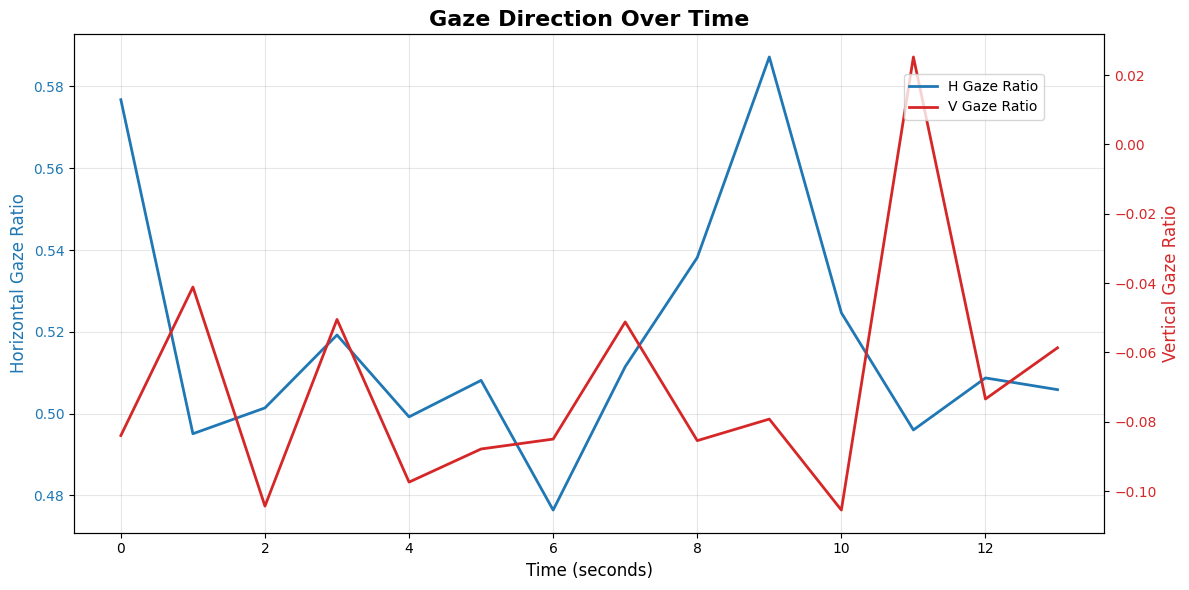

In [72]:
import matplotlib.pyplot as plt
# -----------------------------
# Simple twin-axis plot (recommended)
# -----------------------------
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot horizontal gaze ratio (left/right)
color1 = 'tab:blue'
ax1.set_xlabel('Time (seconds)', fontsize=12)
ax1.set_ylabel('Horizontal Gaze Ratio', color=color1, fontsize=12)
ax1.plot(df['Time'], df['h_ratio'], color=color1, linewidth=2, label='H Gaze Ratio')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3)

# Second Y-axis for vertical gaze ratio (up/down)
ax2 = ax1.twinx()
color2 = 'tab:red'
ax2.set_ylabel('Vertical Gaze Ratio', color=color2, fontsize=12)
ax2.plot(df['Time'], df['v_ratio'], color=color2, linewidth=2, label='V Gaze Ratio')
ax2.tick_params(axis='y', labelcolor=color2)

# Title & legend
plt.title('Gaze Direction Over Time', fontsize=16, fontweight='bold')
fig.legend(loc="upper right", bbox_to_anchor=(0.88, 0.88))

plt.tight_layout()
plt.show()

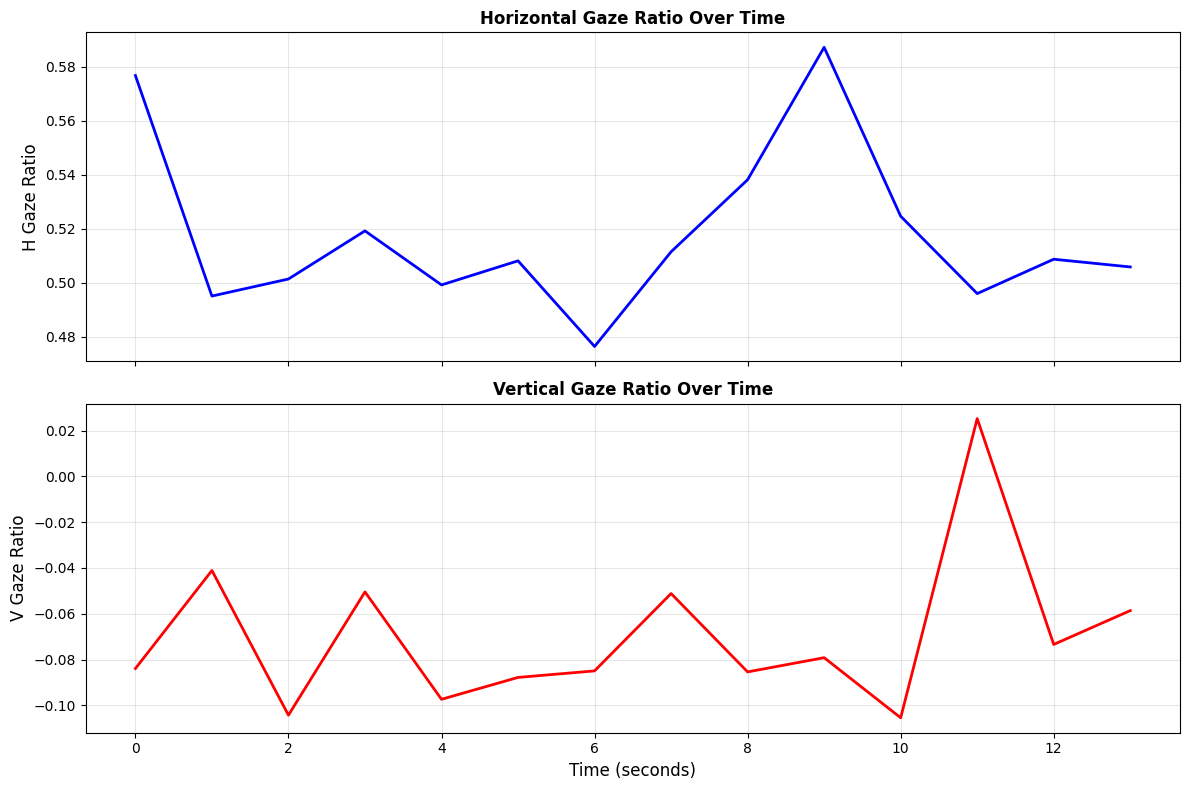

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(df['Time'], df['h_ratio'], 'b-', linewidth=2)
ax1.set_ylabel('H Gaze Ratio', fontsize=12)
ax1.set_title('Horizontal Gaze Ratio Over Time', fontweight='bold')
ax1.grid(True, alpha=0.3)

ax2.plot(df['Time'], df['v_ratio'], 'r-', linewidth=2)
ax2.set_xlabel('Time (seconds)', fontsize=12)
ax2.set_ylabel('V Gaze Ratio', fontsize=12)
ax2.set_title('Vertical Gaze Ratio Over Time', fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()